In [1]:

import os
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Import Data
X = pd.read_csv('../data/X_train.csv', index_col=0)
y = pd.read_csv('../data/y_train.csv', index_col=0)
y[y == -1] = 0


In [3]:
# Drop Object Columns
X = X.select_dtypes(exclude=['object'])

In [4]:
# Make Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# 01 - Naive LGB

In [5]:
# Naive LGBM
clf_naive = lgb.LGBMClassifier()
clf_naive.fit(X_train, y_train)

C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8394
[LightGBM] [Info] Number of data points in the train set: 33600, number of used features: 420
[LightGBM] [Info] Start training from score -4.267423
[LightGBM] [Info] Start training from score -1.567902
[LightGBM] [Info] Start training from score -1.218865
[LightGBM] [Info] Start training from score -1.266925
[LightGBM] [Info] Start training from score -1.608248


LGBMClassifier()

In [6]:
# Evaluate Train Accuracy
y_pred_train = clf_naive.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.79


In [7]:
# Evaluate Test Accuracy
y_pred = clf_naive.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.64


# 02 - Some Tuning

In [8]:
# Prepare lbg dataset
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [9]:
# Train Model
params = {
    "num_leaves": 10,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,                
    "learning_rate": 0.05,
    "objective": "multiclass",
    "boost_from_average": True,
    "early_stopping_round": 50,
    "num_class" : 5,
}

model = lgb.train(
    params,
    d_train,
    10000,
    valid_sets=[d_test],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8394
[LightGBM] [Info] Number of data points in the train set: 33600, number of used features: 420
[LightGBM] [Info] Start training from score -4.267423
[LightGBM] [Info] Start training from score -1.567902
[LightGBM] [Info] Start training from score -1.218865
[LightGBM] [Info] Start training from score -1.266925
[LightGBM] [Info] Start training from score -1.608248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid_0's multi_logloss: 0.851492


In [10]:
# Evaluate Train Accuracy
y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.73


In [11]:
# Evaluate Train Accuracy
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
train_accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.64


# Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

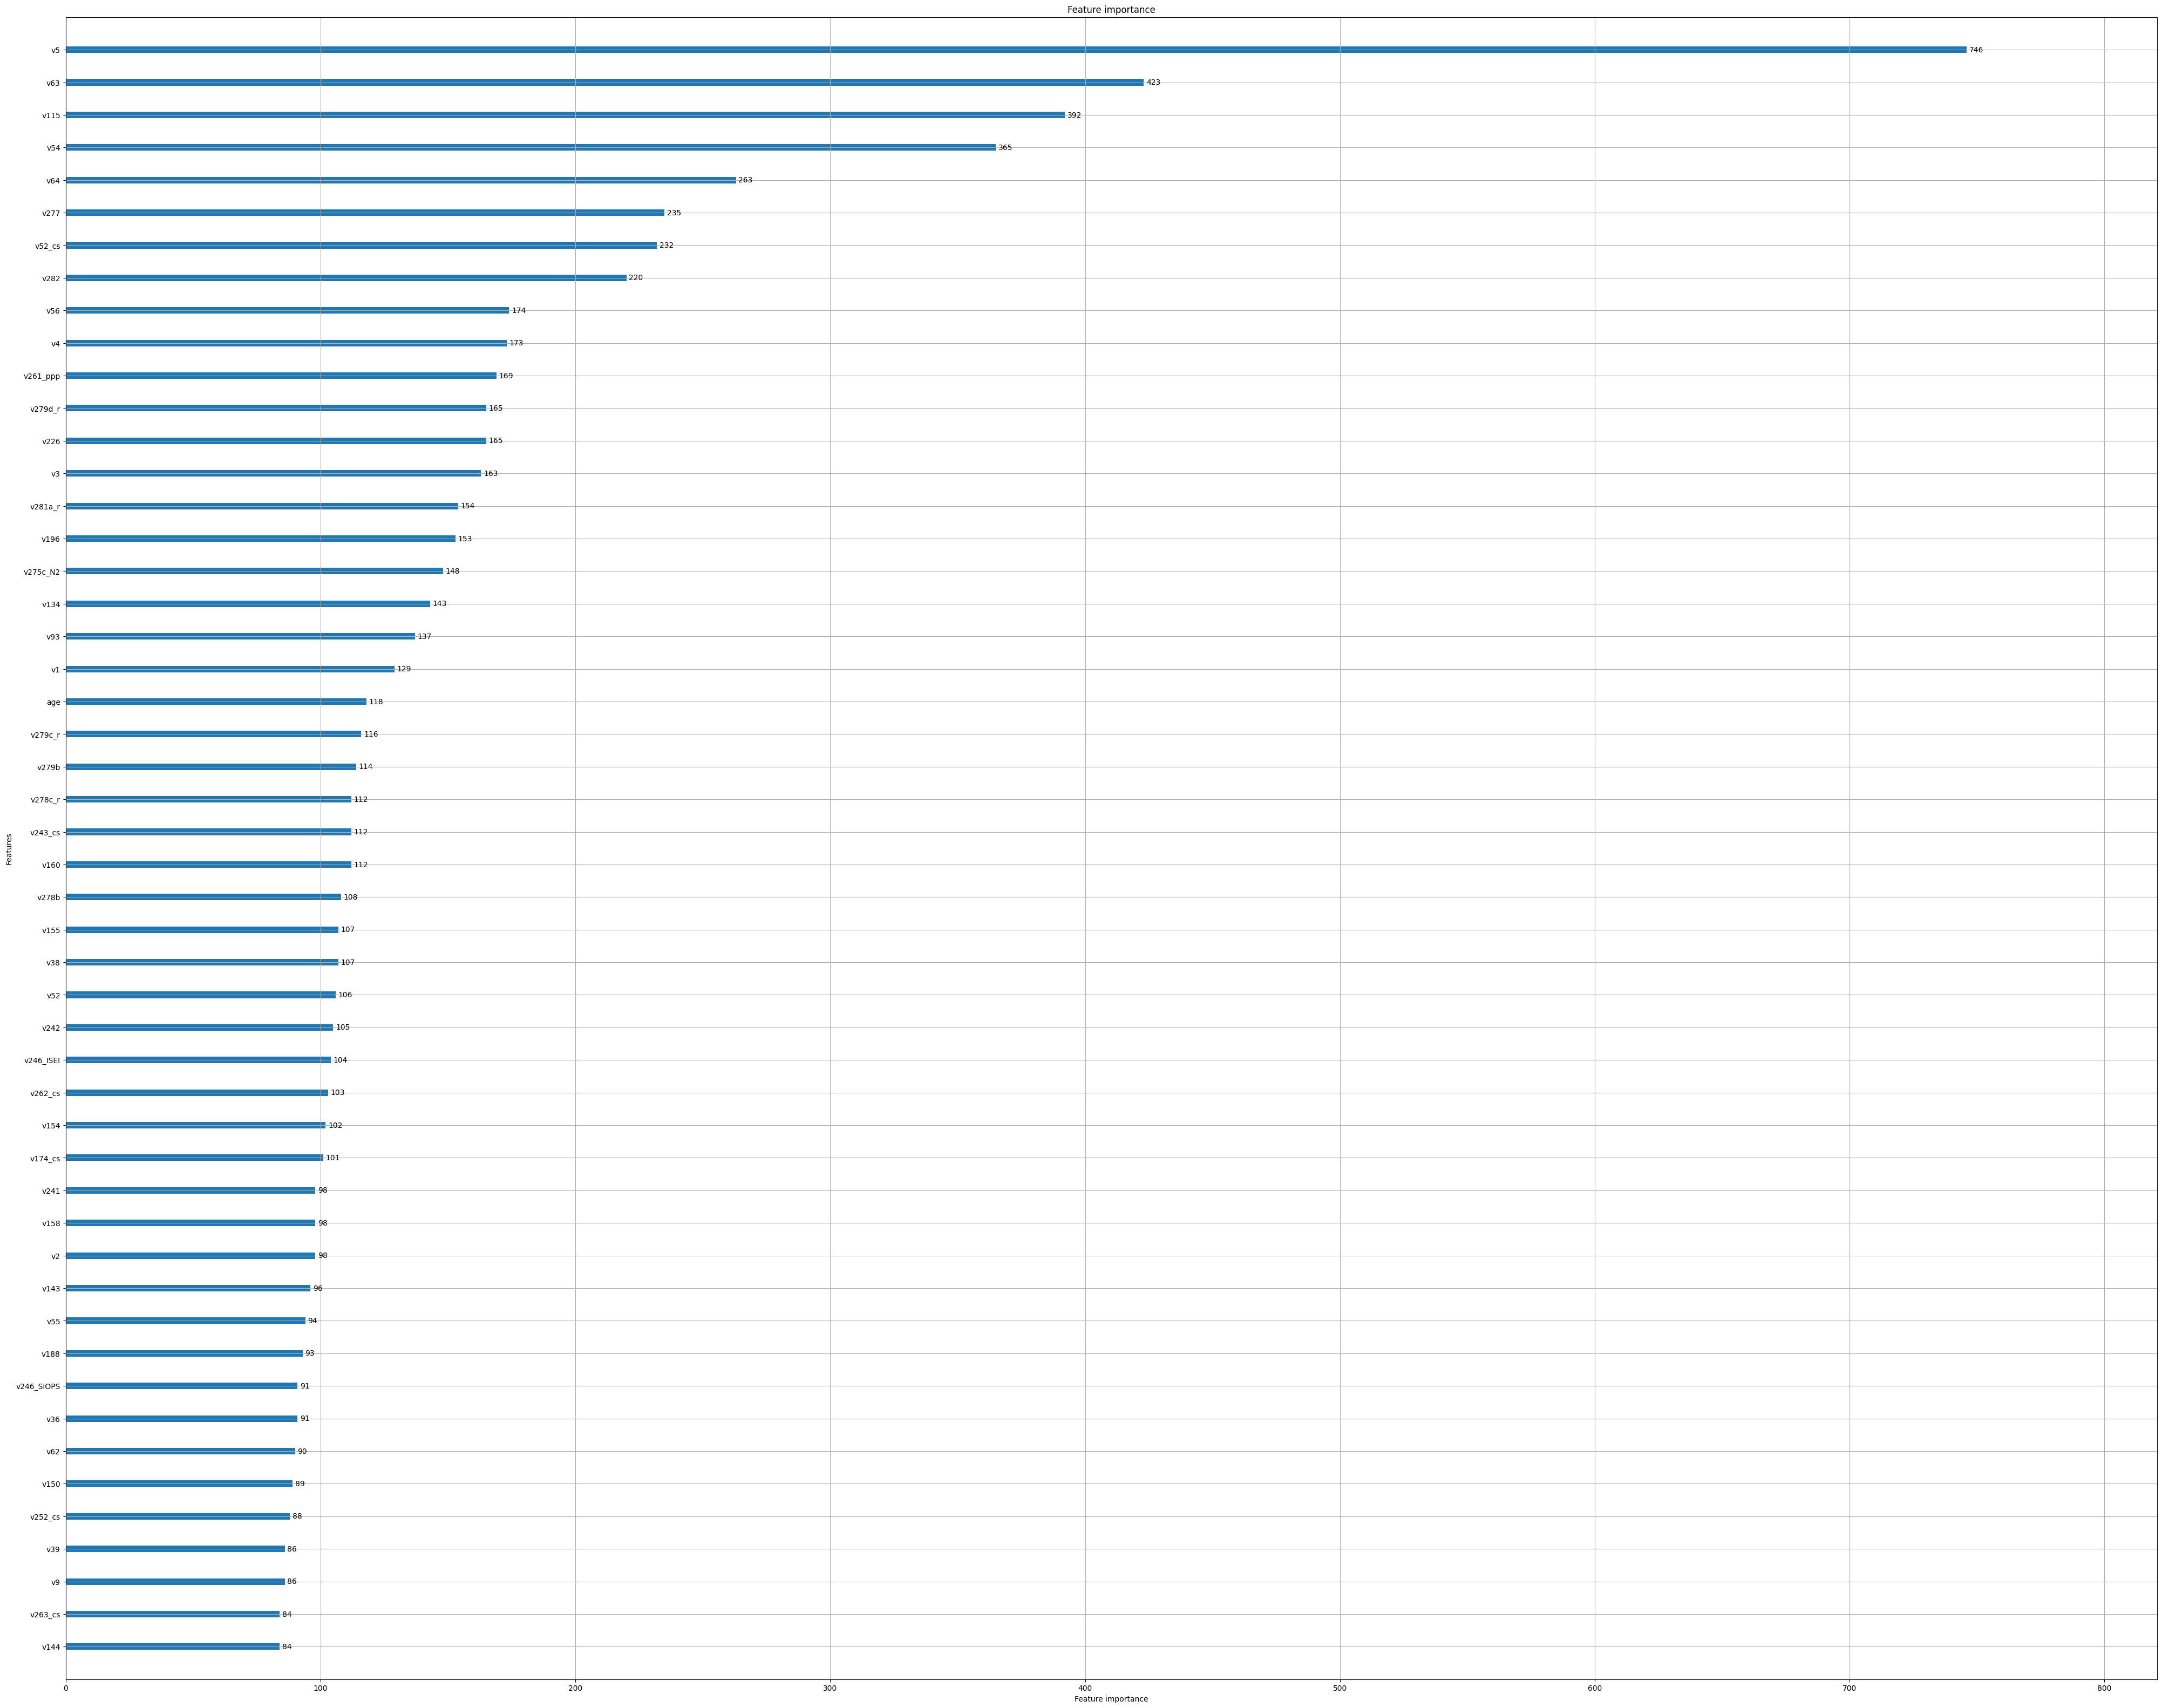

In [23]:
lgb.plot_importance(model, max_num_features=50, figsize=(50,40))

# Submission

In [18]:
X_test_subm = pd.read_csv('../data/X_test.csv', index_col=0)
X_test_subm = X_test_subm.select_dtypes(exclude=['object'])

In [19]:
# Train Model on Full Data
params = {
    "num_leaves": 10,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,                
    "learning_rate": 0.05,
    "objective": "multiclass",
    "boost_from_average": True,
    "num_class" : 5,
}

final_model = lgb.LGBMRegressor(**params)
final_model.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 420
[LightGBM] [

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, boost_from_average=True,
              feature_fraction=0.8, learning_rate=0.05, metric='multi_logloss',
              num_class=5, num_leaves=10, objective='multiclass')

In [20]:
predictions = final_model.predict(X_test_subm)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [21]:
# Make a df of preds
preds_df = pd.DataFrame(predictions, columns=['no answer', 'very important', 'quite important', 'not important', 'not at all important'])
preds_df.index.name = 'id'
print(preds_df.shape)
preds_df.head()

(11438, 5)


,no answer,very important,quite important,not important,not at all important
id,,,,,
0,0.003306,0.624920,0.180274,0.150321,0.041179
1,0.008152,0.114442,0.751024,0.110637,0.015745
2,0.015958,0.196130,0.386632,0.356443,0.044838
3,0.013057,0.159865,0.586740,0.187066,0.053272
4,0.006788,0.311724,0.545037,0.114975,0.021477


In [22]:
# Save to CSV
preds_df.to_csv('../data/predictions2.csv')
